# Analysis

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from sklearn.metrics import confusion_matrix
import nltk
from nltk.util import ngrams
from bidict import bidict
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from statistics import mean
import sys
import os
import kenlm
from itertools import product
if "/u/solimanz/development/career_prediction_gpu/" not in sys.path:
    sys.path.append("/u/solimanz/development/career_prediction_gpu/")

/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('dark'))

In [22]:
def topK_accs_df(result_dict, seq_lengths):
    df_dict = {"model": [],
               "length": [],
               "acc": [],
               "top_2_acc": [],
               "top_3_acc": [],
               "top_4_acc": [],
               "top_5_acc": []}
    
    df_dict = defaultdict(list)
    
    
        
    return pd.DataFrame(df_dict)

def groupby_length(seq_lengths):
    d = dict()    
    for i in range(2, seq_lengths.max()+1):
        d[i] = np.where(seq_lengths == i)[0]
        
    return d

def next_batch(path):
    batch = 0
    name = os.path.basename(path)
    while os.path.exists(os.path.join(path, f"{name}_batch_{batch}.npy")):
        with open(os.path.join(path, f"{name}_batch_{batch}.npy"), "rb") as f:
            matrix = np.load(f)
        batch += 1
        yield matrix
        
def accuracy_by_length(preds, targets, groups, k=1):
    """
    preds: predictions of the model (n_examples, max_length, n_labels)
    targets: prediction targets with shape (n_examples, max_lenth, n_labels)
    groups: dictionary grouping the indices of the input sequences by length"""
    
    length_acc = dict()    
    for length, indices in groups.items():
        if len(indices) > 0:
            if len(preds.shape) == 3:
                p = preds[indices, length-1, :]
                t = np.argmax(targets[indices, length-1, :], axis=1)
                length_acc[length] = top_k_acc(p, t, k)
            else:
                p = preds[indices]
                t = targets[indices]
                length_acc[length] = top_k_acc(p, t, k)
        
    return length_acc

def to_python_lists(np_arr, lengths):
    return [row[:length] for row, length in zip(np_arr, lengths)]

def count_transitions(sequences):
    trans = [list(zip(seq[:-1], seq[1:])) for seq in sequences]
    trans = sum(trans, [])
    
    return Counter(trans)

def normalize_counter(counts):
    total = sum(counts.values(), 0)
    for key in counts:
        counts[key] /= total
    
    return counts

def top_k_acc(preds, targets, k=1):
    """
    preds has shape (n_examples, n_labels)
    targets has shape (n_examples, 1)
    """

    sorted_args = (-preds).argsort(axis=1)[:,:k]
    tt = np.tile(targets, (k,1)).T
    acc = np.mean(np.sum(sorted_args == tt, axis=1))
    return acc

def acc_df(preds, targets):
    ks = list(range(1,11))
    df_dict = {"model": [], "top_k": [], "value": []}

    for name, ps in preds.items():
        for k in ks:
            df_dict["model"].append(name)
            df_dict["top_k"].append(k)
            df_dict["value"].append(round(top_k_acc(ps, targets, k), 5)*100)
            
    return pd.DataFrame(df_dict)

def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def get_index(target, top_preds):    
    indices = np.where(top_preds == target)[0]
    if len(indices) == 0:
        return -1
    
    return indices[0]

In [56]:
def get_generator(name, features=None, dataset="top550"):
    base_path = "/data/rali7/Tmp/solimanz/data/"
    predictions_path = os.path.join(base_path, "model_predictions")
    
    if not features:
        features = 'jobid'
    
    if name == "target" or name == 'inputs' or name == 'seq_length':
        path = os.path.join(predictions_path, dataset, "jobid", name)
    else:
        path = os.path.join(predictions_path, dataset, features, name)
    
    return next_batch(path)

## Fetching the Results

In [24]:
df_path = "/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_reduced.pkl"
base_path = "/data/rali7/Tmp/solimanz/data/"
top550_path = os.path.join(base_path, "datasets", "top550")
reduced7000_path = os.path.join(base_path, "datasets", "reduced7000")

In [25]:
#with open(os.path.join(top550_path, "jobid", "data.json"), "r") as f:
#    data = json.load(f)
with open(os.path.join(reduced7000_path, "jobid", "data.json"), "r") as f:
    data = json.load(f)

In [45]:
data.keys()

dict_keys(['title_to_id', 'train_data', 'test_data', 'maximum_seq_len'])

In [60]:
nb_preds_path = "/data/rali7/Tmp/solimanz/data/baseline_preds/best/multi_nb-preds_reduced7000.npy"
nb_targets_path = "/data/rali7/Tmp/solimanz/data/baseline_preds/best/multi_nb-targets_reduced7000.npy"

In [61]:
targets_path = os.path.join(predictions_path, "top550", "jobid", "targets")
inputs_path = os.path.join(predictions_path, "top550", "jobid", "inputs")
seq_lengths_path = os.path.join(predictions_path, "top550", "jobid", "seq_lengths")

bow_predictions_path = os.path.join(predictions_path, "top550", "bow", "predictions")
jobid_predictions_path = os.path.join(predictions_path, "top550", "jobid", "predictions")
title_emb_predictions_path = os.path.join(predictions_path, "top550", "title_emb", "predictions")

NameError: name 'predictions_path' is not defined

In [62]:
names = ['target', 'inputs', 'seq_lengths']
features = ['jobid', 'bow', 'title_emb']

In [64]:
#get sequence lengths
seq_len_gen = get_generator(name='seq_lengths', dataset='reduced7000')

accumulator = []

for arr in seq_len_gen:
    accumulator.append(arr)
    
seq_lengths = np.concatenate(accumulator, axis=0)
del accumulator

In [49]:
test = data["test_data"]

In [73]:
del test_seq_len

In [61]:
np.all(np.equal(seq_lengths, test_seq_len[:len(seq_lengths)]))

True

In [ ]:
pred_gen = get_generator(name='predictions',dataset='reduced7000')
seq_len_gen = get_generator(name='seq_lengths', dataset='reduced7000')
target_gen = get_generator(name='targets', dataset='reduced7000')
num_examples = 0

results_dict = {"fasttext_topK": [], "target": [], "seq_length": []}

for preds, targets, lengths in zip(pred_gen, target_gen, seq_len_gen):
    num_examples += preds.shape[0]
    preds = preds.reshape((preds.shape[1], preds.shape[2], preds.shape[3]))
    
    # get last prediction and target
    for pred_row, target_row, l in zip(preds, targets, lengths):
        results_dict["fasttext_topK"].append((-pred_row[l-1]).argsort())
        results_dict["target"].append(np.argmax(target_row[l-1]))
        results_dict["seq_length"].append(l)

In [77]:
with open('/data/rali7/Tmp/solimanz/data/pickles/results_dict.pkl', 'wb') as f:
    pickle.dump(file=f, obj=results_dict)

In [83]:
inputs_gen = get_generator(name='inputs', dataset='reduced7000')
seq_len_gen = get_generator(name='seq_lengths', dataset='reduced7000')
input_seqs = []

for i, l in zip(inputs_gen, seq_len_gen):
    for row, length in zip(i,l):
        input_seqs.append(row[:length])

In [87]:
title_id = bidict(data['title_to_id'])

In [90]:
title_id.inv[1054]

'communications director'

In [ ]:
#get last targets
target_gen = get_generator(name='targets', dataset='reduced7000')

accum = []

for targets in target_gen:
    start = 0
    stop = targets.shape[0]
    indicies = seq_lengths[start:stop] - 1
    x = np.array(range(targets.shape[0]))
    z = np.array(range(targets.shape[2]))
    accum.append(np.argmax(np.array([row[i] for i, row in zip(indicies, targets)]), axis=1))

In [90]:
np.save('/data/rali7/Tmp/solimanz/data/model_predictions/reduced7000/all_targets.npy', targets)

In [ ]:
targets = []
inputs = []
seq_lengths = []

jobid_preds = []
bow_preds = []
title_emb_preds = []

for i, t, sl, title_emb in zip(inputs_gen,
                                           targets_gen,
                                           seq_length_gen,
                                           title_emb_preds_gen):
    inputs.append(i)
    targets.append(t)
    seq_lengths.append(sl)

    title_emb_preds.append(title_emb.reshape((title_emb.shape[1],title_emb.shape[2], title_emb.shape[3])))
    
    

In [ ]:
preds = dict()

In [ ]:
inputs = np.concatenate(inputs, axis=0)
targets = np.concatenate(targets, axis=0)
seq_lengths = np.concatenate(seq_lengths, axis=0)
preds["jobid"] = np.concatenate(jobid_preds, axis=0)
preds["bow"] = np.concatenate(bow_preds, axis=0)
preds["fasttext"] = np.concatenate(title_emb_preds, axis=0)

In [ ]:
z = np.zeros((preds["bow"].shape[0], 1, preds["bow"].shape[2]))
preds["bow"] = np.concatenate([preds["bow"], z], axis=1)
del z

In [ ]:
nb_preds = np.load(nb_preds_path)
nb_targets = np.load(nb_targets_path)

In [ ]:
xs = to_python_lists(inputs, seq_lengths)
ys = to_python_lists(targets, seq_lengths)
preds["jobid"] = to_python_lists(preds["jobid"], seq_lengths)
preds["bow"] = to_python_lists(preds["bow"], seq_lengths)
preds["fasttext"] = to_python_lists(preds["fasttext"], seq_lengths)

In [ ]:
del jobid_preds
del title_emb_preds
del bow_preds

### Focus Analysis on Last Output

In [ ]:
ys = np.array([np.argmax(seq[-1], axis=0) for seq in ys])
preds["jobid"] = [seq[-1] for seq in preds["jobid"]]
preds["bow"] = [seq[-1] for seq in preds["bow"]]
preds["fasttext"] = [seq[-1] for seq in preds["fasttext"]]

In [ ]:
preds["nb"] = nb_preds

In [ ]:
for k, v in preds.items():
    if k != "nb":
        preds[k] = np.array(preds[k])

## Distribution of Labels and Transitions in Training Set

In [16]:
train = data["train_data"]
test = data["test_data"]
title_to_id = bidict(data["title_to_id"])

test_inputs = [[str(i) for i in seq[:-1]] for seq in test]
test_targets = [seq[-1] for seq in test]

#train = [[title_to_id.inv[i] for i in seq] for seq in train]
#test = [[title_to_id.inv[i] for i in seq] for seq in test]

### Preparing Data for KenLM

In [17]:
train_txt = "\n".join([" ".join([str(i) for i in seq]) for seq in train])

In [19]:
with open('train_7000.txt', 'w') as f:
    f.write(train_txt)

### KenLM

In [115]:
test_inputs = [[str(i) for i in seq] for seq in input_seqs]

In [123]:
def kenlm_predict(test, model_binary='bigram7000.binary'):    
    model = kenlm.Model(f"../../kenlm/build/{model_binary}")
    model_preds = np.zeros((len(test), 7000))
    
    if model_binary == 'bigram7000.binary':
        n = 2
    elif model_binary == 'trigram7000.binary':
        n = 3
    elif model_binary == '4gram7000.binary':
        n = 4
    elif model_binary == '5gram7000.binary':
        n = 5
        
    for j, seq in enumerate(test):
        test_seq = seq[-(n-1):]
        for i in range(7000):
            model_preds[j][i] = model.score(" ".join(test_seq + [str(i)]))
            
    return model_preds

In [179]:
#bigram_preds = kenlm_predict(test_inputs, model_binary='bigram7000.binary')
trigram_preds = kenlm_predict(test_inputs, model_binary='trigram7000.binary')
#preds['4gram'] = kenlm_predict(test_inputs, model_binary='4gram7000.binary')
#preds['5gram'] = kenlm_predict(test_inputs, model_binary='5gram7000.binary')

KeyboardInterrupt: 

In [128]:
np.save('/data/rali7/Tmp/solimanz/data/pickles/bigram_preds.npy', bigram_preds)

In [197]:
def compute_preds(model='trigram'):
    preds = kenlm_predict(test_inputs, model_binary=f'{model}7000.binary')
    res = []
    for p in preds:
        res.append(list((-p).argsort()[:10]))
    return res

In [198]:
for m in ['bigram', 'trigram', '4gram', '5gram']:    
    results_dict[f"{m}_topK"] = compute_preds(m)

In [202]:
with open('/data/rali7/Tmp/solimanz/data/pickles/results_dict.pkl', 'wb') as f:
    pickle.dump(file=f, obj=results_dict)

In [201]:
results_dict.keys()

dict_keys(['fasttext_topK', 'target', 'seq_length', 'bigram_topK', 'nb_topK', 'trigram_topK', '4gram_topK', '5gram_topK'])

In [131]:
for preds in bigram_preds:
    results_dict["bigram_topK"].append(preds.argsort())

In [132]:
results_dict.keys()

dict_keys(['fasttext_topK', 'target', 'seq_length', 'bigram_topK'])

In [134]:
results_dict['fasttext_topK'] = [ list(seq[:10]) for seq in results_dict["fasttext_topK"]]
results_dict['bigram_topK'] = [ list(seq[:10]) for seq in results_dict["bigram_topK"]]

In [139]:
nb_preds = np.load('/data/rali7/Tmp/solimanz/data/baseline_preds/best/multi_nb-preds_reduced7000.npy')

In [147]:
nb_preds = nb_preds[:167400]

In [151]:
results_dict["nb_topK"] = []
for preds in nb_preds:
    results_dict["nb_topK"].append((-preds).argsort()[:10])

In [158]:
results_dict.keys()

dict_keys(['fasttext_topK', 'target', 'seq_length', 'bigram_topK', 'nb_topK'])

In [162]:
np.mean(np.equal([1,2,3], [1,2,4]))

0.6666666666666666

In [172]:
np.tile(results_dict['target'], (2,1)).T

array([[   0,    0],
       [2358, 2358],
       [  56,   56],
       ...,
       [   6,    6],
       [  37,   37],
       [ 675,  675]])

In [6]:
def get_results_dict(k=1, results=None):
    
    if not results:
        with open('/data/rali7/Tmp/solimanz/data/pickles/results_dict.pkl', 'rb') as f:
            results = pickle.load(f)

    results['fasttext'] = []
    results['bigram'] = []
    resutls['naive_bayes'] = []
    
    for ft, bigram, nb in zip(results['fasttext_topK'], results['bigram_topK'], results['nb_topK']):
        results['fasttext'].append(ft[k-1])
        results['bigram'].append(bigram[k-1])
        results['naive_bayes'].append(nb[k-1])


def get_topk_acc(k=1, model='fasttext', results=None):    
    predicted_values = np.array(results[f'{model}_topK'])
    tt = np.tile(results['target'], (k,1)).T
    acc = np.mean(np.sum(np.equal(predicted_values[:,:k], tt), axis=1))
    return acc

In [4]:
with open('/data/rali7/Tmp/solimanz/data/pickles/results_dict.pkl', 'rb') as f:
            results = pickle.load(f)

## Distribution of Job Title Targets

In [261]:
train_targets = [seq[-1] for seq in data['train_data']]

In [262]:
target_counts = normalize_counter(Counter(train_targets))

In [265]:
train_targets = [i for i in target_counts.items()]

In [271]:
train_targets = sorted(train_targets, key=lambda t: t[0], reverse=False)

Text(0.5,0,'Unique Job Title ID Number')

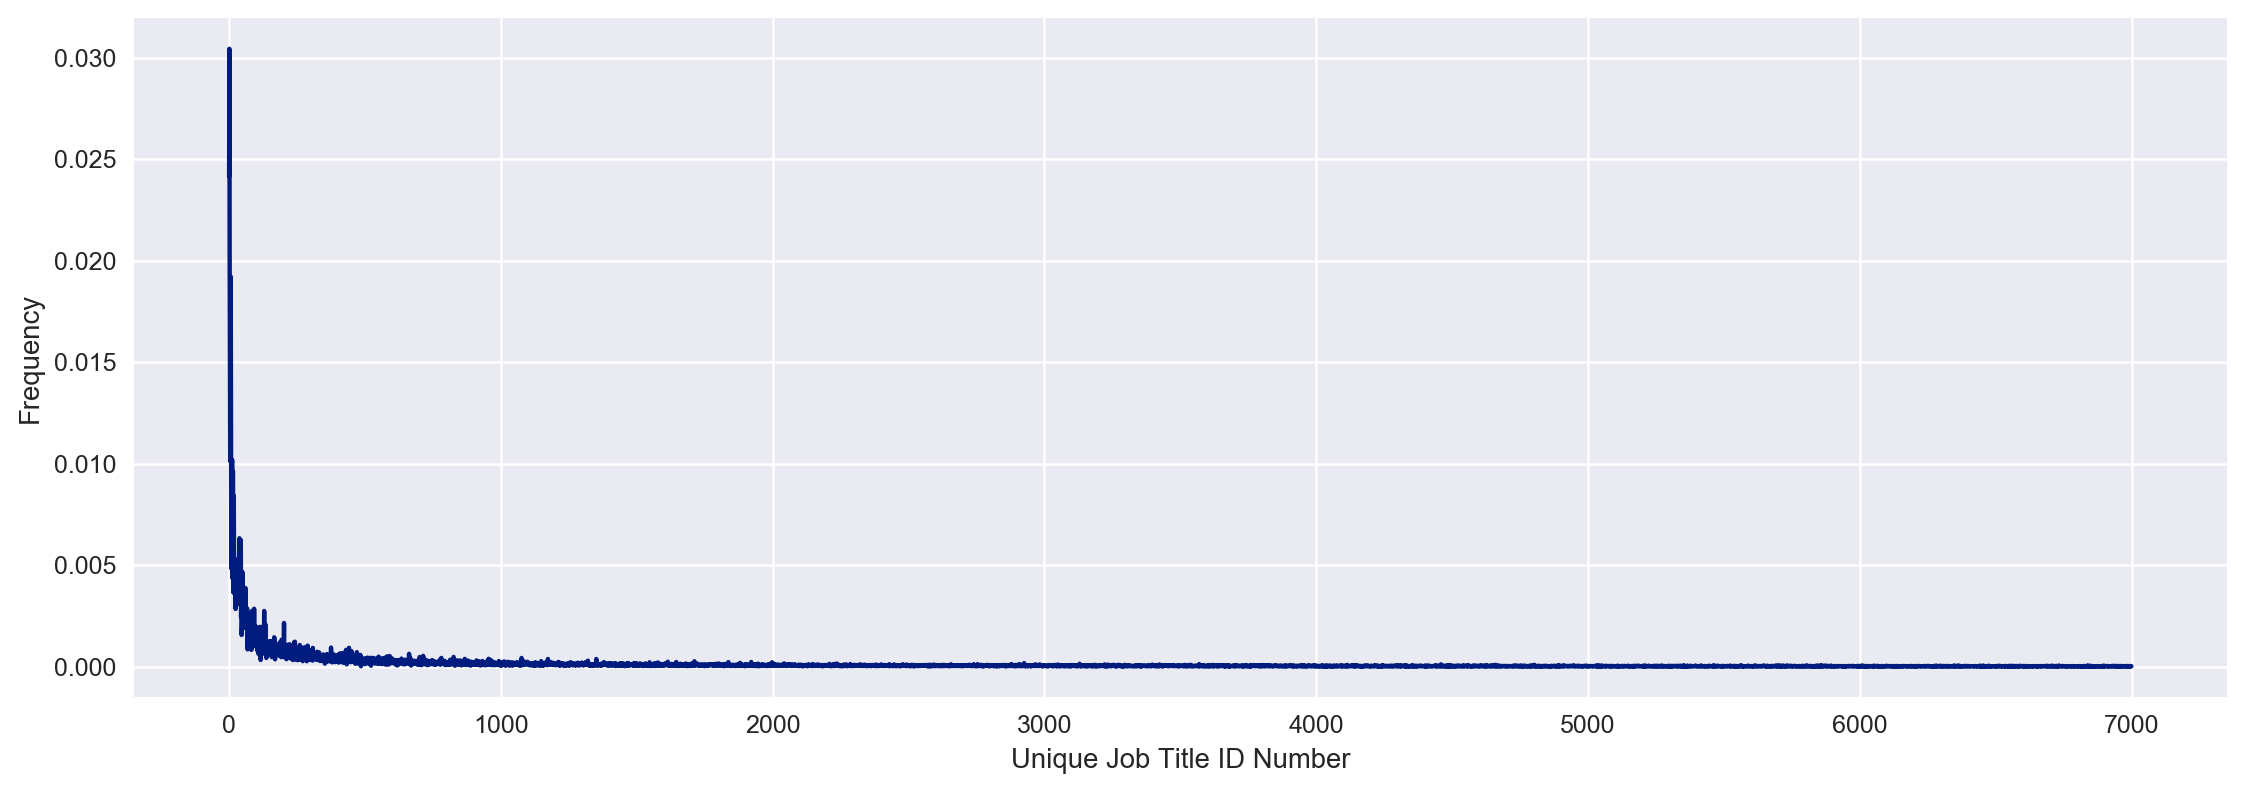

In [274]:
x = [t[0] for t in train_targets]
y = [t[1] for t in train_targets]
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 180
plt.plot(x,y)
plt.ylabel("Frequency")
plt.xlabel("Unique Job Title ID Number")

## Accuracy Comparison

In [309]:
models= ['nb', 'fasttext', 'bigram', 'trigram', '4gram', '5gram']

In [310]:
acc_dict = defaultdict(list)

for model in models:
    for k in range(1, 11):
        acc_dict['model'].append(model)
        acc_dict['top_k'].append(k)
        acc_dict['accuracy'].append(get_topk_acc(k, model, results_dict) * 100)

In [311]:
acc_df = pd.DataFrame(acc_dict)

In [312]:
plt.rcParams["figure.figsize"] = 2, 7
plt.rcParams["figure.dpi"] = 200

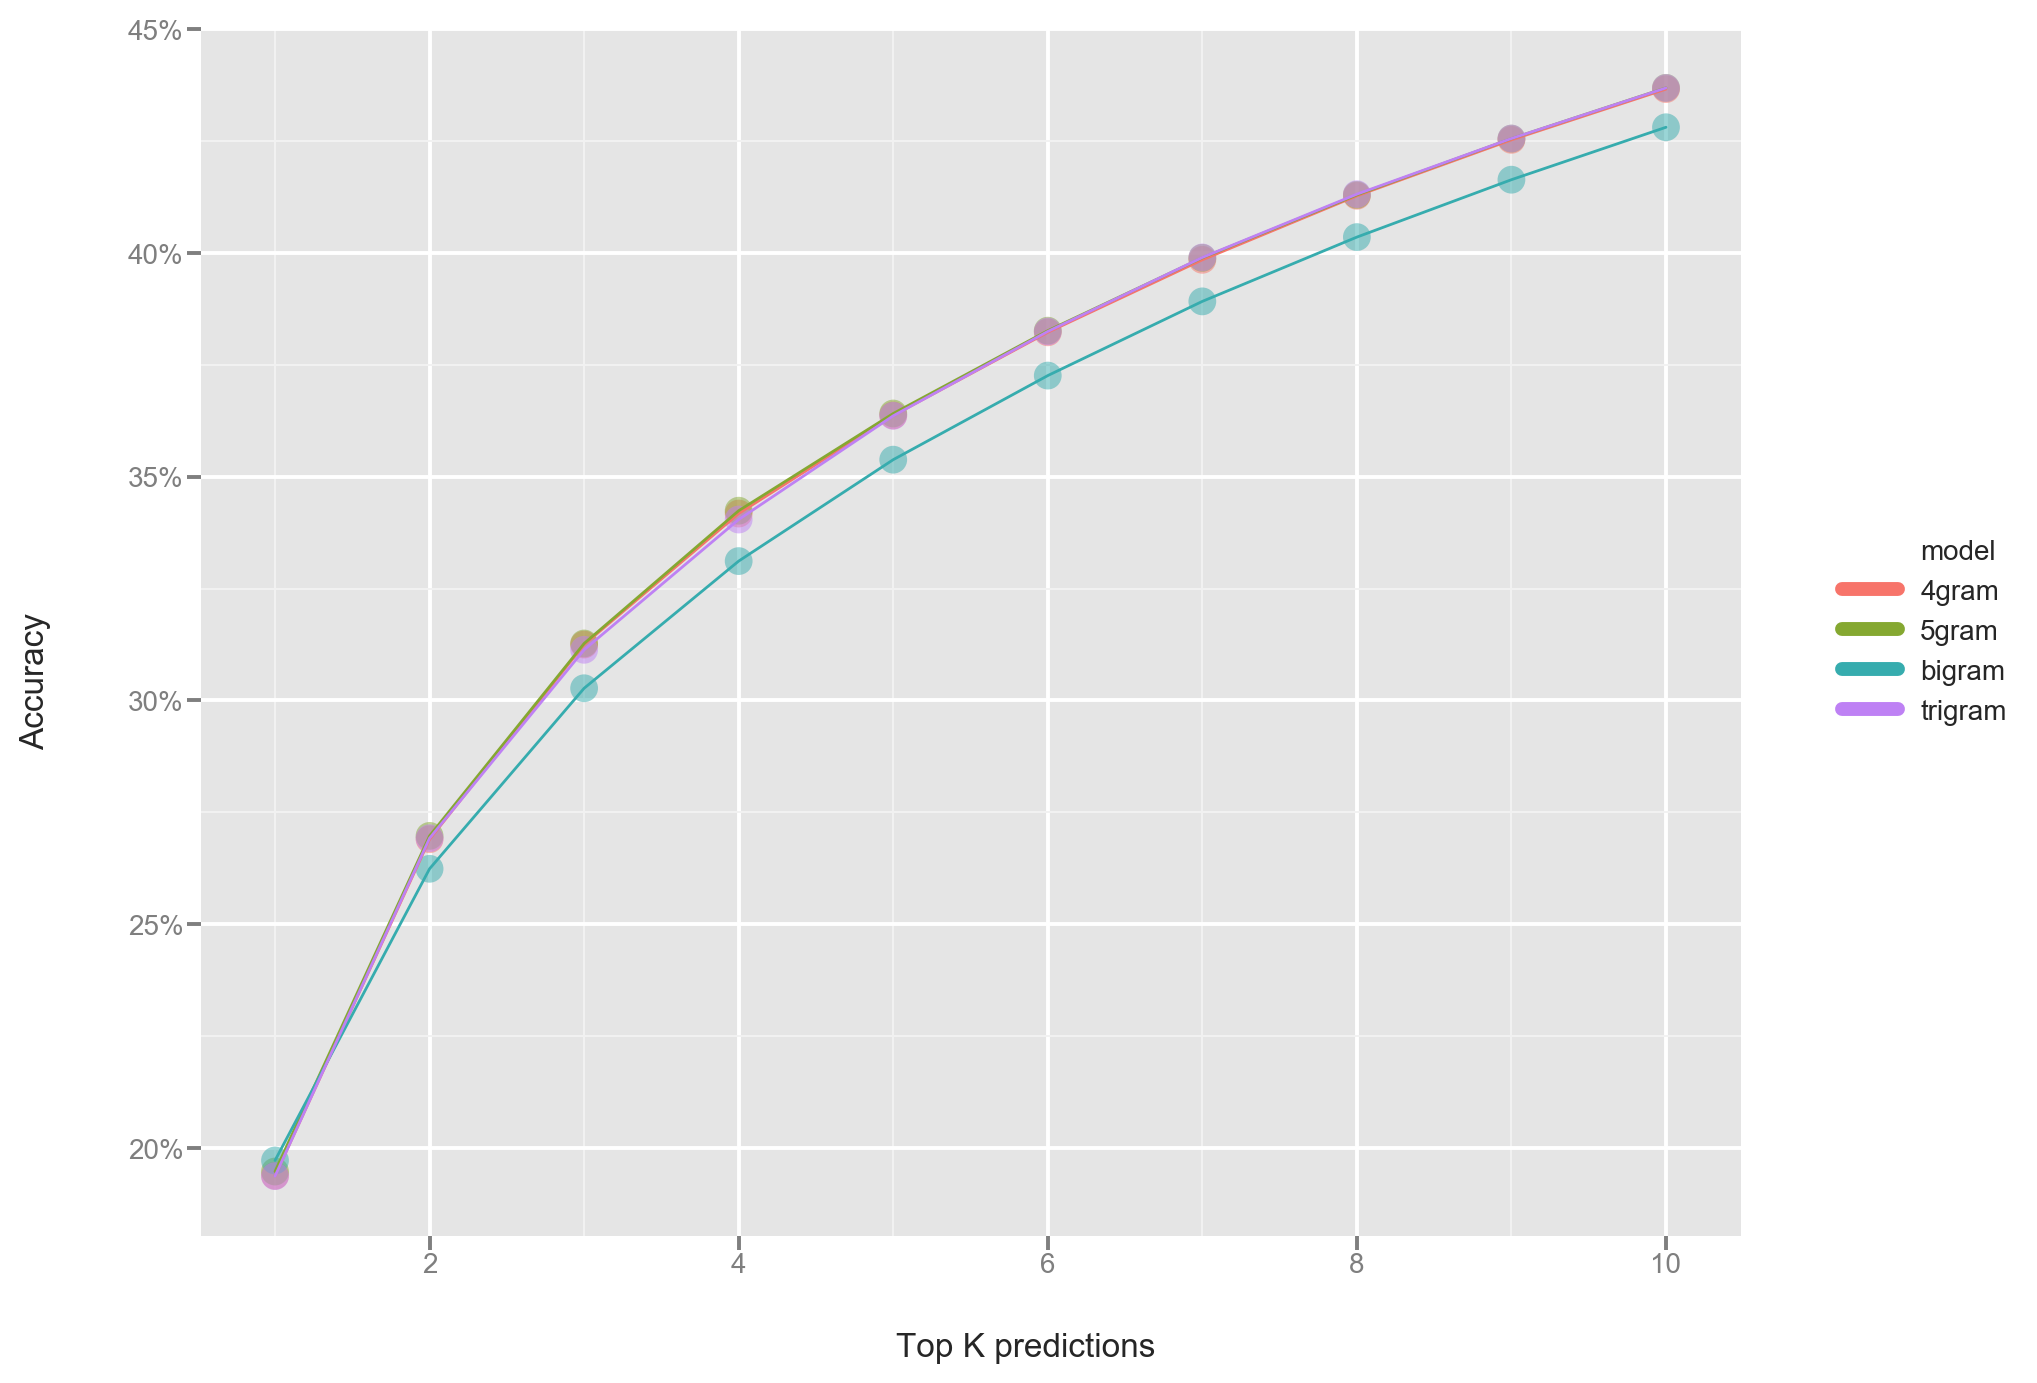

<ggplot: (-9223363254408289150)>

In [259]:
ggplot(aes(x='top_k', y='accuracy', color='model'), data=acc_df[acc_df.model.isin(["bigram", "trigram", "4gram", "5gram"])]) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \
+ scale_y_continuous(breaks=[20, 25, 30, 35, 40, 45],
                     labels=['20%', '25%', '30%', '35%', '40%', '45%']) \


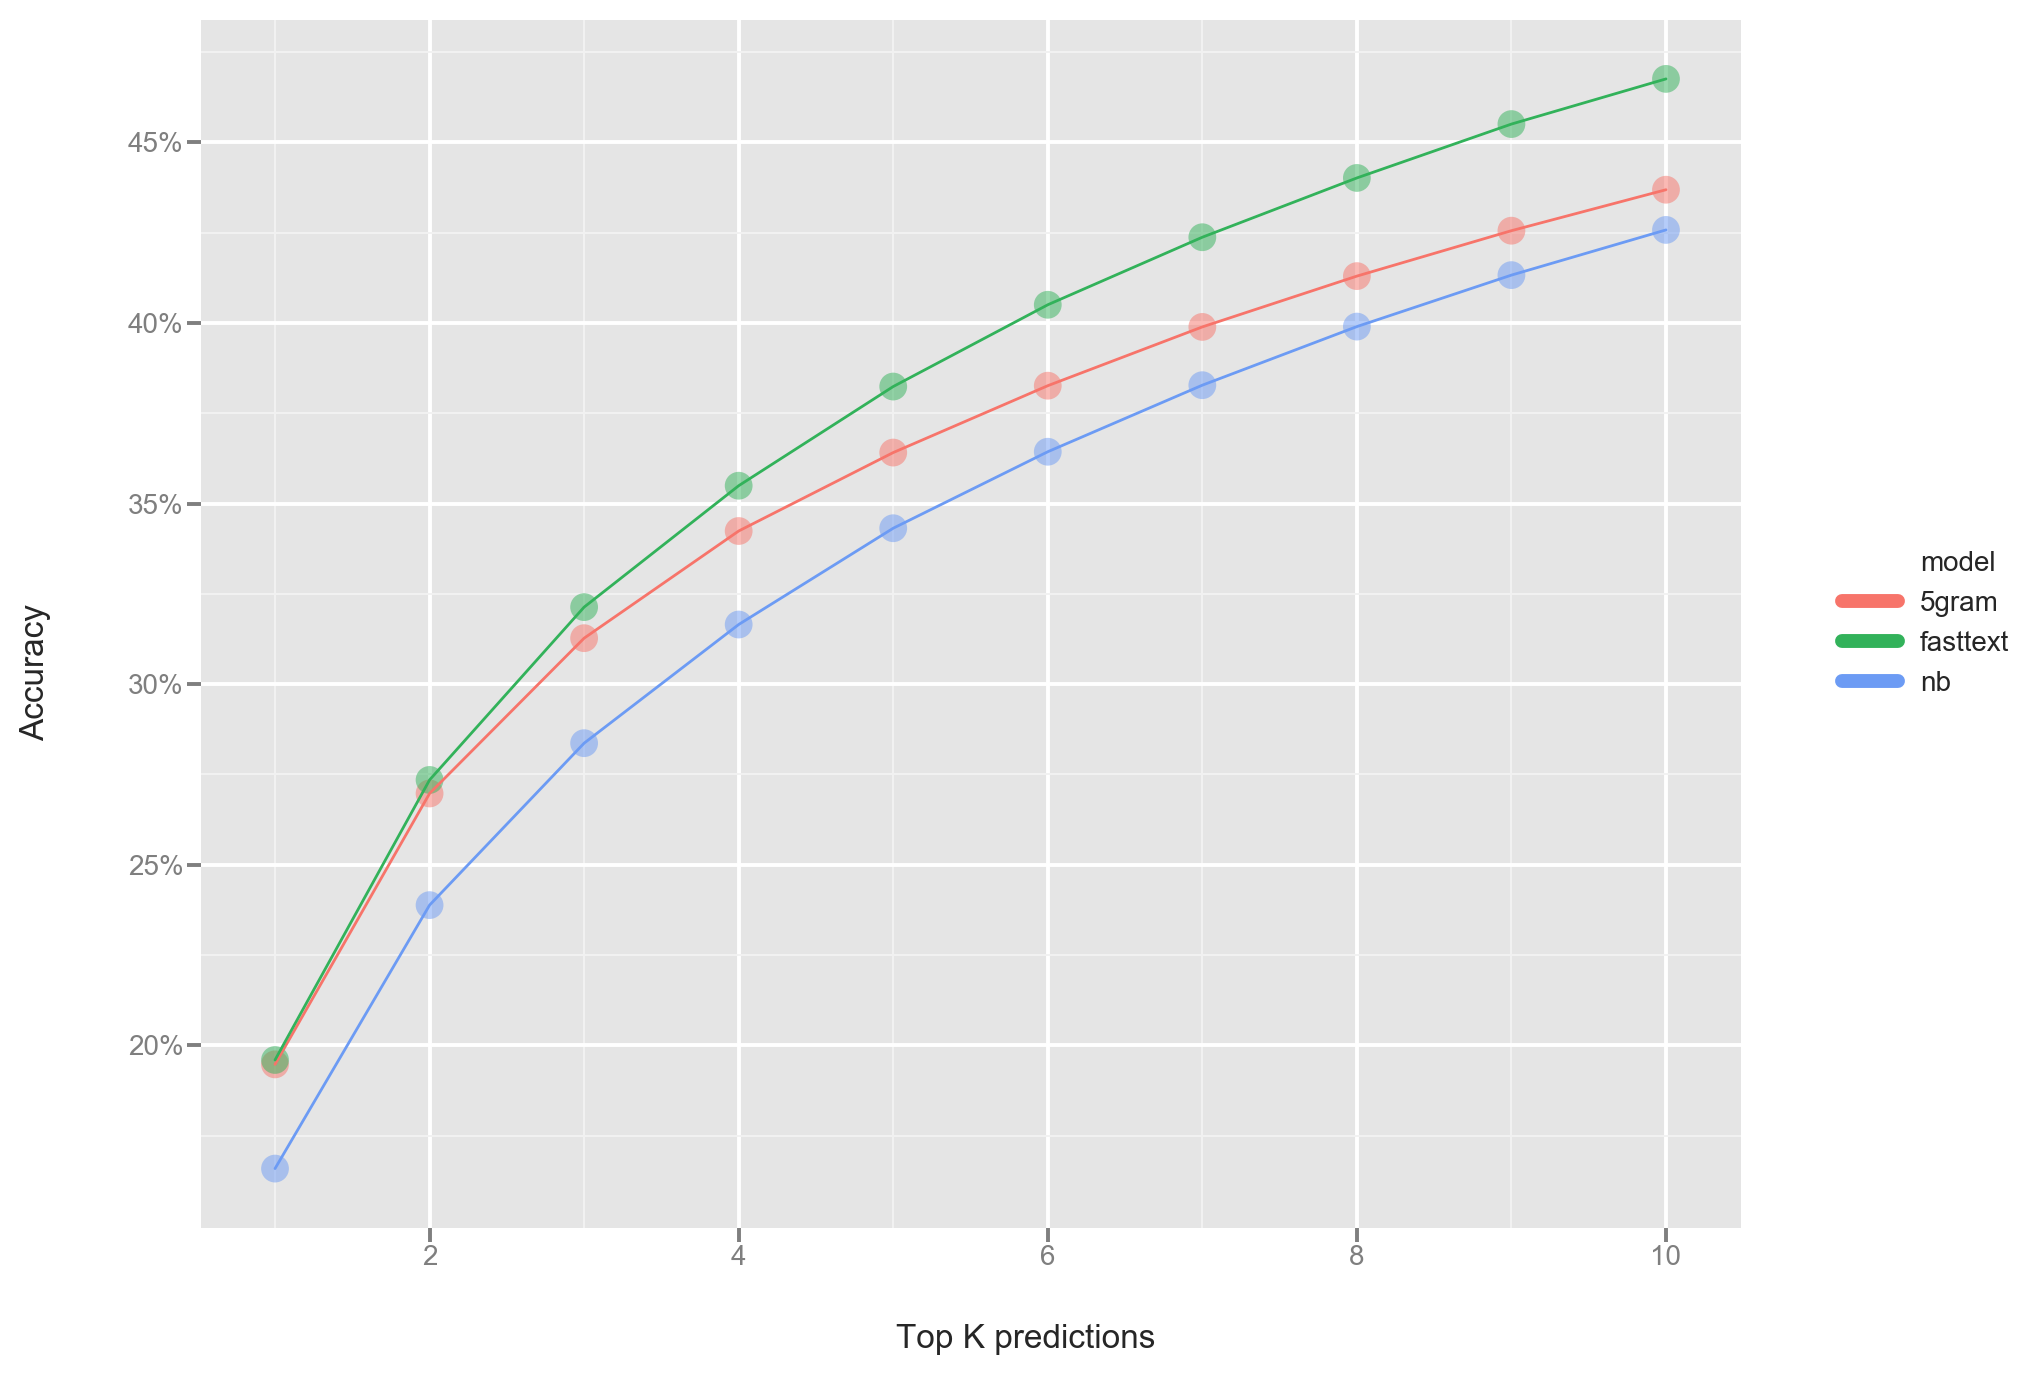

<ggplot: (-9223363254458948804)>

In [313]:
ggplot(aes(x='top_k', y='accuracy', color='model'), data=acc_df[acc_df.model.isin(["5gram", "fasttext", "nb"])]) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \
+ scale_y_continuous(breaks=[20, 25, 30, 35, 40, 45],
                     labels=['20%', '25%', '30%', '35%', '40%', '45%']) \


In [5]:
res = pd.DataFrame(results)

## Accuracy by length of sequence

In [297]:
acc_dict = defaultdict(list)

for l in res.seq_length.unique():
    d = res[res.seq_length == l].to_dict('list')
    
    for model in models:
        acc_dict['length'].append(l)
        acc_dict['model'].append(model)
        for k in range(1,11):          
            
            if k == 1:
                acc_dict['accuracy'].append(get_topk_acc(k, model, d) * 100)
            else:
                acc_dict[f'top{k}'].append(get_topk_acc(k, model, d) * 100)
    

In [298]:
accs = pd.DataFrame(acc_dict)

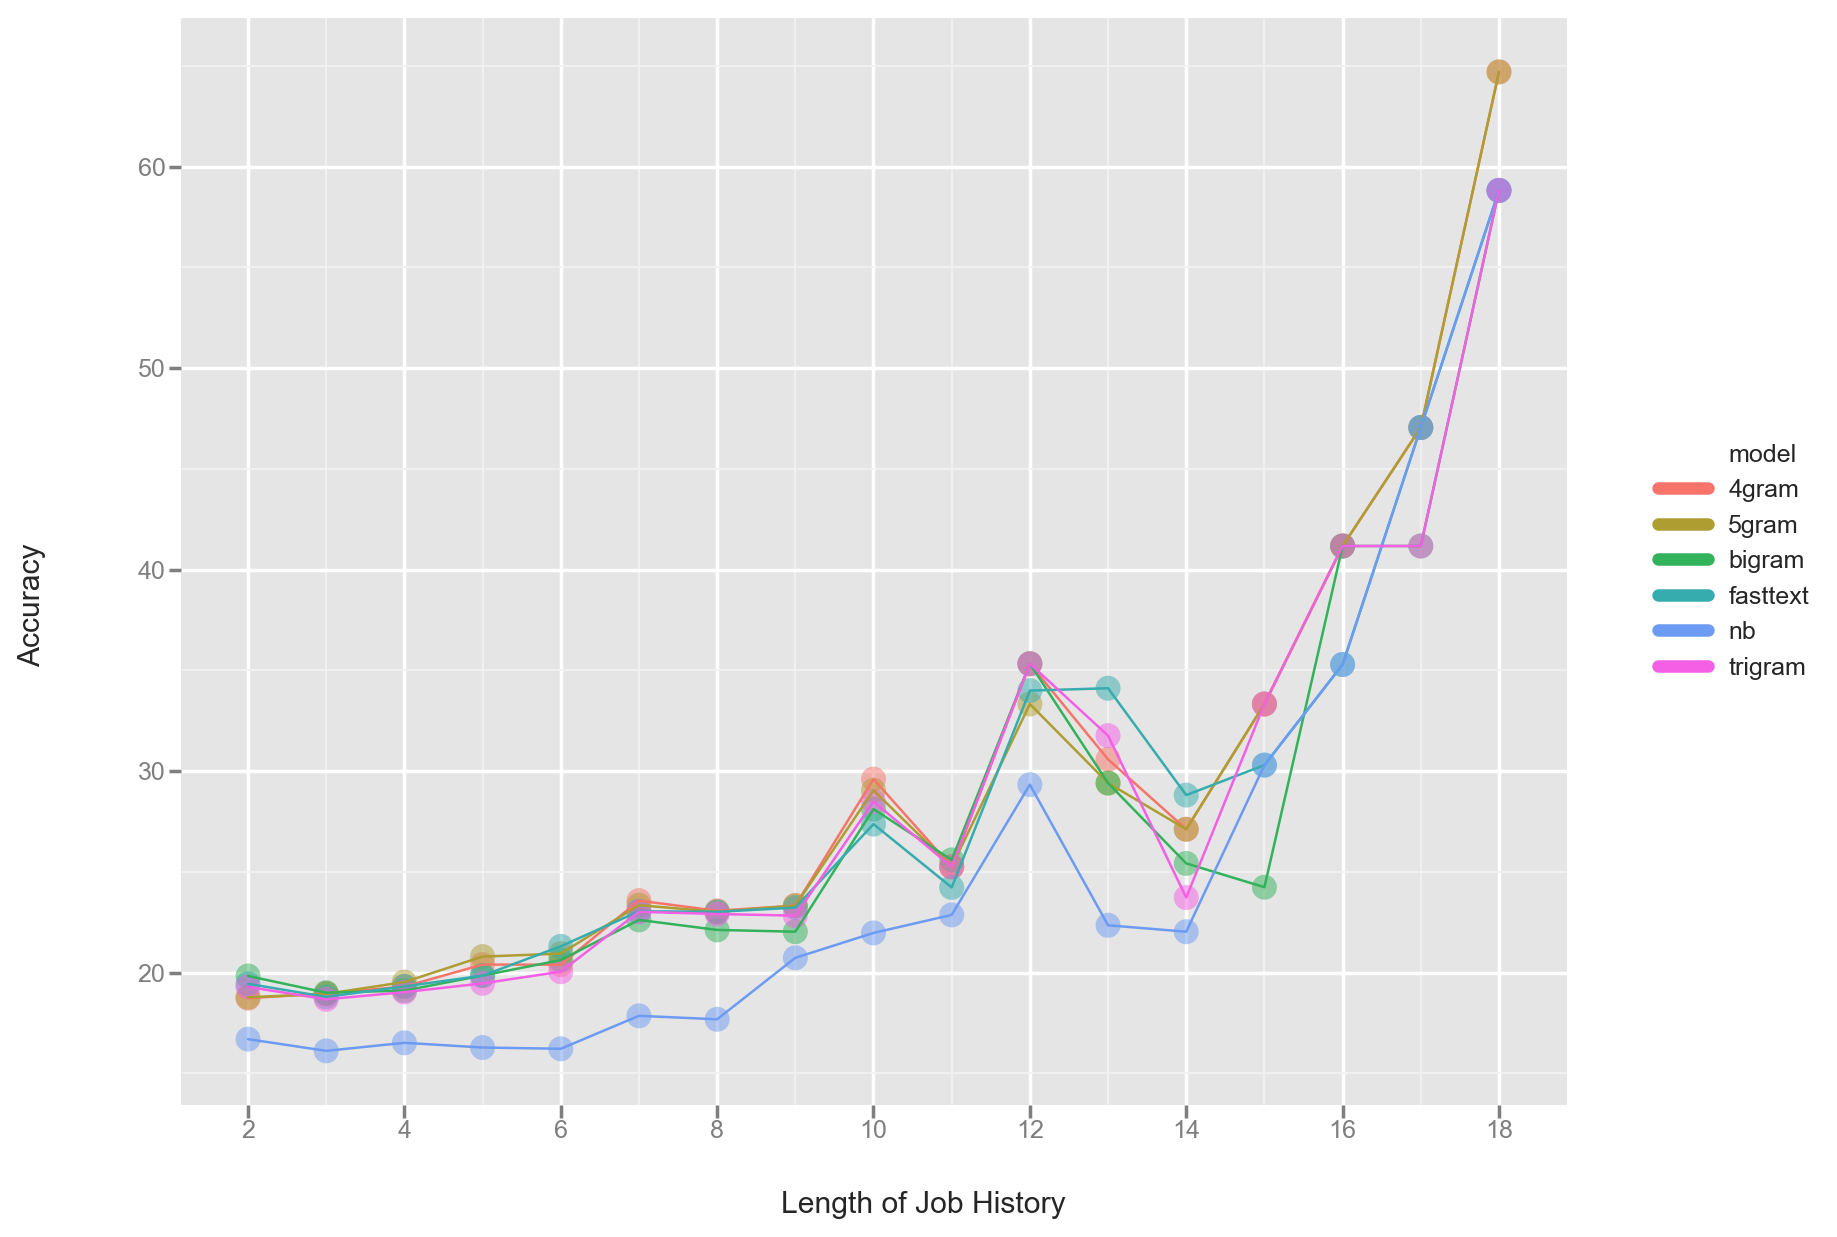

<ggplot: (-9223363254450007054)>

In [308]:
ggplot(aes(x='length', y='accuracy', color='model'), data=accs[accs.length <= 18]) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ xlab("Length of Job History") \
+ ylab("Accuracy") \
#+ scale_y_continuous(breaks=[16, 17, 18, 19, 20, 21, 22, 23],
#                     labels=['16%', '17%', '18%', '19%', '20%', '21%', '22%', '23%']) \

## Distribution of Length of Job History

In [18]:
length_counts = res.seq_length.value_counts(normalize=True)

Text(0,0.5,'Frequency')

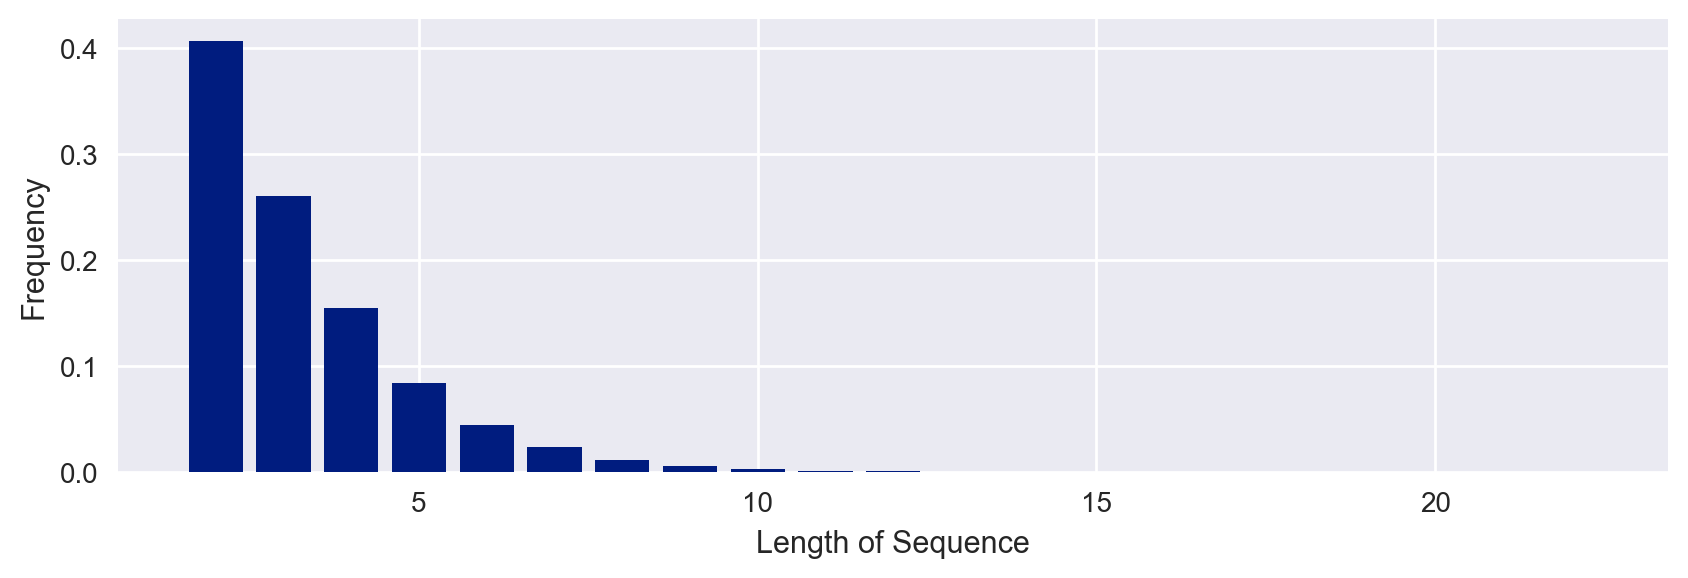

In [21]:
plt.rcParams["figure.figsize"] = 10, 3
plt.rcParams["figure.dpi"] = 200
plt.bar(length_counts[:21].index.values, length_counts[:21].values)
plt.xlabel('Length of Sequence')
plt.ylabel('Frequency')

## Frequency of change Through time

In [26]:
train = data['train_data']

In [27]:
by_length = defaultdict(list)
for seq in train:
    by_length[len(seq)].append(get_ngrams(2, seq))
    
seqs_trans = [get_ngrams(2, seq) for seq in train]

change_freq = {}
totals = {}

for i in range(31):
    changed = 0.0
    total = 0.0
    
    for seq in seqs_trans:
        if i < len(seq):
            total += 1
            trans = seq[i]
            if trans[0] != trans[1]:
                changed += 1
                
    change_freq[i+1] = changed/total
    totals[i+1] = total

In [28]:
x = []
y = []

for k, v in change_freq.items():
    x.append(k)
    y.append(v)

Text(0.5,0,'Job Timeline')

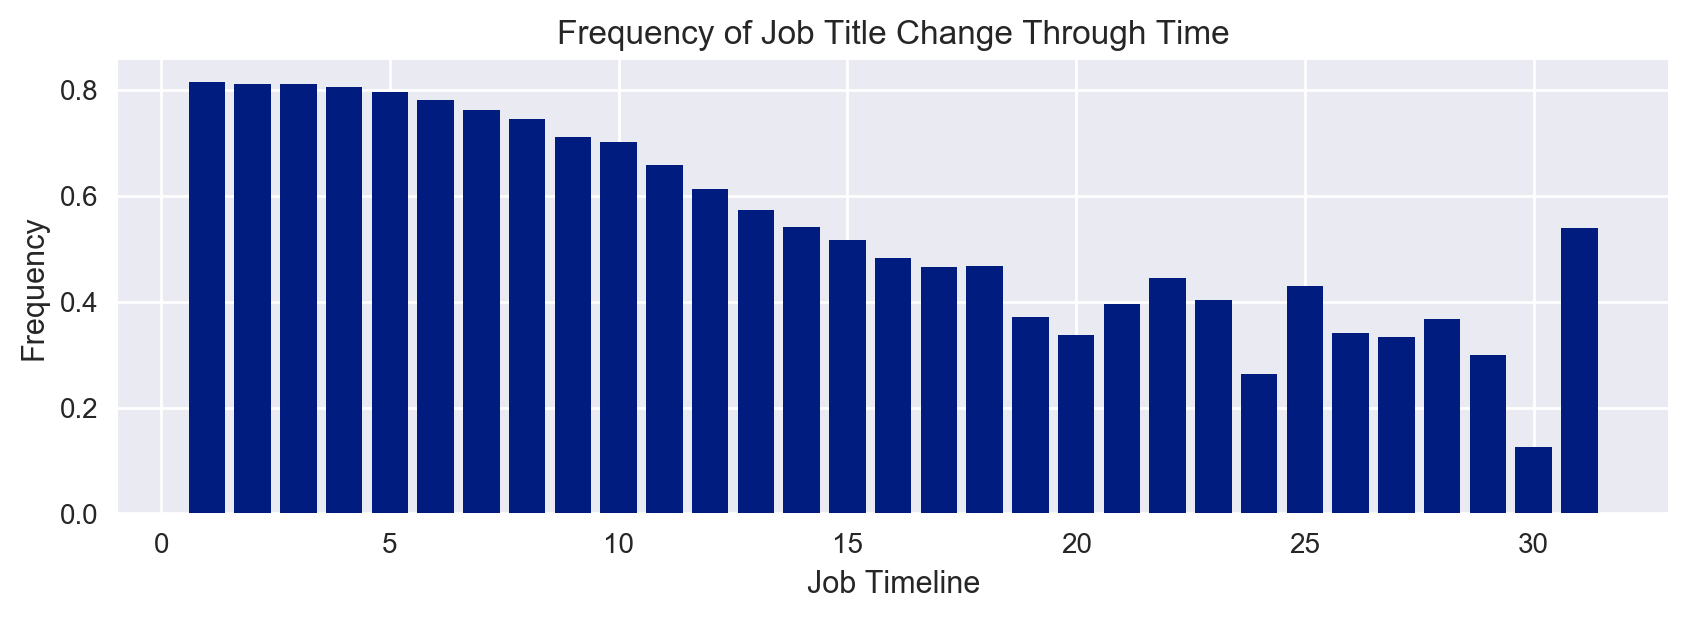

In [29]:
plt.bar(x, y)
plt.title("Frequency of Job Title Change Through Time")
plt.ylabel("Frequency")
plt.xlabel("Job Timeline")